In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

The KdV equation is often written in a slightly different form, e.g.,
\begin{equation}
\partial_t u + 6 u \partial_x u  + \partial_x^3 u = 0 \tag{1.18}
\end{equation}

# решение в виде солитона с пьедесталом, которое 
обобщает решение Слюняева--Пелиновскогопри $D=0$ 
\begin{equation}\label{Blin_eq72a}
 u(t, x) = D + \frac{{k}^{2}}{1 + 
\mathrm{cosh}\left(k (x - (6 D + k^2) t)\right)} .
\end{equation} 

In [2]:
def ex1(t, x, args):
    k, D = args
    return D + k**2/(1 + cosh(k*(x - (6*D + k**2)*t)))

Одно-солитонное решение представляет собой бегущую волну 
$\xi = k (x - 4 k^{2} t)$, зависящую от параметра $k$, которая распространяется без изменения формы и амплитуды~\cite[стр. 294]{Polyanin:2023}:
\begin{equation}\label{eq2}
u = \frac{2 k^{2}}{\cosh^{2}{\xi} }
\end{equation}

In [3]:
def ex2(t, x, args):
    k = args[0]
    return 2*k**2*(1 - tanh(k*x - 4*k**3*t)**2)

Двух-солитонное решение описывает взаимодействие двух волн
$\xi_1 = k_1(x - 4 k_1^{2} t)$ и $\xi_2 = k_2(x - 4 k_2^{2} t)$, зависящих от параметров $k_1$  и $k_2$, при котором они сохраняют свою форму и амплитуду при дальнейшем движении~\cite[стр. 294]{Polyanin:2023}:
\begin{equation}\label{eq3}
u = \dfrac{\left(8 k_{1}^{2} - 8 k_{2}^{2}\right) \left(k_{1}^{2} \cosh^{2}{\xi_2} +
k_{2}^{2} \sinh^{2}{\xi_1}\right)}{
\left(\left(k_{1} - k_{2}\right) \cosh{\left( \xi_1 +
\xi_2\right) } + 
\left(k_{1} + k_{2}\right) \cosh{\left( \xi_1 - \xi_2\right) }\right)^{2}}
\end{equation}

In [4]:
def ex3(t, x, args):
    k1, k2, delta = args
    xi1, xi2 = k1*(x - 4*k1**2*t), k2*(x - 4*k2**2*t) - delta
    return 8*(k1**2 - k2**2)*(k1**2*cosh(xi2)**2 + k2**2*sinh(xi1)**2)/\
        ((k1 - k2)*cosh(xi1 + xi2) + (k1 + k2)*cosh(xi1 - xi2))**2

In [5]:
def draw(sol, exact, loc="best", name=""):
    figure(figsize=(7.5, 9.0))
    
    splt1 = subplot(3, 1, 1)
    ylabel(r'$u(t, x)$')
    xlabel(r'$x$')
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)
    splt2 = subplot(3, 1, 2)
    ylabel(r'error')
    xlabel(r'$x$')
    grid(True)
    splt3 = subplot(3, 1, 3)
    ylabel(r'numeric error')
    xlabel(r'$x$')
    grid(True)
    
    for t, nu, ntau2, nh2, nfda, nerr in sol:
        u = exact(t, x, args)
        splt1.plot(x, nu, label="$t=%.2f$" % t)
        splt2.plot(x, abs(nu - u)/(1 + abs(u)), label="$t=%.2f$" % t)
        splt3.plot(x, abs(nerr)/(1+abs(nu)), label="$t=%.2f$" % t)

    splt1.legend(loc=loc, fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)

    if name: 
        if name[-4:] == ".png":savefig(name, pad_inches=0.0, dpi=300)
        else: savefig(name, pad_inches=0.0)
    else: show()
    close()

def draw1(sol, exact, FDAtau2, FDAh2, p,  args, loc="best", name=""):
    figure(figsize=(15.0, 12.0))
    
    n = 4
    splt1 = subplot(n, 2, 1)
    ylabel(r'FDA $\tau^2$')
    xlabel(r'$x$')
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)

    splt3 = subplot(n, 2, 3)
    ylabel(rf'FDA $h^{p}$')
    xlabel(r'$x$')
    grid(True)
    
    splt5 = subplot(n, 2, 5)
    ylabel(r'FDA')
    xlabel(r'$x$')
    grid(True)

    splt7 = subplot(n, 2, 7)
    ylabel(r'error')
    xlabel(r'$x$')
    grid(True)

    splt2 = subplot(n, 2, 2)
    ylabel(r'numeric FDA $\tau^2$')
    xlabel(r'$x$')
    grid(True)
    
    splt4 = subplot(n, 2, 4)
    ylabel(rf'numeric FDA $h^{p}$')
    xlabel(r'$x$')
    grid(True)

    splt6 = subplot(n, 2, 6)
    ylabel(r'numeric FDA')
    xlabel(r'$x$')
    grid(True)

    splt8 = subplot(n, 2, 8)
    ylabel(r'numeric error')
    xlabel(r'$x$')
    grid(True)

    serr, kerr = 0., 0.
    for t, nu, ntau2, nh2, nfda, nerr in sol[1:]:
        u, tau2, h2 = exact(t, x, args), FDAtau2(t, x, args), FDAh2(t, x, args)
        fda = tau2*dt**2 + h2*dx**p
        splt1.plot(x, tau2*dt**2, label="$t=%.2f$" % t)
        splt2.plot(x, ntau2, label="$t=%.2f$" % t)
        splt3.plot(x, h2*dx**p, label="$t=%.2f$" % t)
        splt4.plot(x, nh2, label="$t=%.2f$" % t)
        splt5.plot(x, fda, label="$t=%.2f$" % t)
        splt6.plot(x, nfda, label="$t=%.2f$" % t)
        splt7.plot(x, abs(nu - u)/(1 + abs(u)), label="$t=%.2f$" % t)
        splt8.plot(x, abs(nerr)/(1 + abs(nu)), label="$t=%.2f$" % t)
    splt7.legend(loc=loc, fancybox=True)
    splt8.legend(loc=loc, fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    
    if name: 
        if name[-4:] == ".png":savefig(name, pad_inches=0.0, dpi=300)
        else: savefig(name, pad_inches=0.0)
    else: show()
    close()

In [6]:
def fda2(fi):
    fi_x, fi_xx = zeros_like(fi[2]), zeros_like(fi[2])
    fi1_x, fi3_x = zeros_like(fi[2]), zeros_like(fi[2])
    fi1_xx, fi3_xx = zeros_like(fi[2]), zeros_like(fi[2])

    fi1_x[1:-1] = (-fi[1][:-2] + fi[1][2:])/(2*dx)
    fi_x[1:-1] =  (-fi[2][:-2] + fi[2][2:])/(2*dx)
    fi3_x[1:-1] = (-fi[3][:-2] + fi[3][2:])/(2*dx)

    fi_xx[1:-1] = (fi[2][:-2] - 2*fi[2][1:-1] + fi[2][2:])/dx**2

    fi1_xx[1:-1] = (fi[1][:-2] - 2*fi[1][1:-1] + fi[1][2:])/dx**2

    fi3_xx[1:-1] = (fi[3][:-2] - 2*fi[3][1:-1] + fi[3][2:])/dx**2

    fi_t = (-fi[1] + fi[3])/(2*dt)
    fi_tx = (-fi1_x + fi3_x)/(2*dt)
    fi_txx = (-fi1_xx + fi3_xx)/(2*dt)
    fi_ttx = (fi3_x - 2*fi_x + fi1_x)/dt**2
    fi_ttt = (-fi[0] + 2*fi[1] - 2*fi[3] + fi[4])/(2*dt**3)
    
    return fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt
        
def fda4(fi):
    fi_x, fi_xx = zeros_like(fi[2]), zeros_like(fi[2])
    fi1_x, fi3_x = zeros_like(fi[2]), zeros_like(fi[2])
    fi1_xx, fi3_xx = zeros_like(fi[2]), zeros_like(fi[2])

    fi1_x[2:-2] = -(fi[1][4:] - 8.*fi[1][3:-1] + 8.*fi[1][1:-3] - fi[1][:-4])/(12*dx)
    fi_x[2:-2] =  -(fi[2][4:] - 8.*fi[2][3:-1] + 8.*fi[2][1:-3] - fi[2][:-4])/(12*dx)
    fi3_x[2:-2] = -(fi[3][4:] - 8.*fi[3][3:-1] + 8.*fi[3][1:-3] - fi[3][:-4])/(12*dx)

    fi1_xx[2:-2] = (-fi[1][:-4] + 16.*fi[1][1:-3] - 30.*fi[1][2:-2] +\
                       16.*fi[1][3:-1] - fi[1][4:])/(12.*dx**2)
    fi_xx[2:-2] = (-fi[2][:-4] + 16.*fi[2][1:-3] - 30.*fi[2][2:-2] +\
                       16.*fi[2][3:-1] - fi[2][4:])/(12.*dx**2)
    fi3_xx[2:-2] = (-fi[3][:-4] + 16.*fi[3][1:-3] - 30.*fi[3][2:-2] +\
                       16.*fi[3][3:-1] - fi[3][4:])/(12.*dx**2)

    fi_t = (-fi[1] + fi[3])/(2*dt)
    fi_tx = (-fi1_x + fi3_x)/(2*dt)
    fi_txx = (-fi1_xx + fi3_xx)/(2*dt)
    fi_ttx = (fi3_x - 2*fi_x + fi1_x)/dt**2
    fi_ttt = (-fi[0] + 2*fi[1] - 2*fi[3] + fi[4])/(2*dt**3)
    
    return fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt

N.J. Zabusky and M.D. Kruskal: Interaction of “solitons” in a collisionless plasma and the recurrence of initial states, Phys. Rev. Lett. 15, 240 (1965)

we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{2 \tau}{h}\left(u^{n}_{i+1} + u^{n}_{i} + u^{n}_{i-1}\right) \left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right)
\end{align}


In [7]:
def solveZabuskyKruskal(u0, u1, dt, dx, t1, n):
    """
    u0, u1 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
#     assert dt <= 2.*dx**3/(3*sqrt(3))
 
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = zeros_like(u0), [(0, u1.copy(), zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(2, int(t1/dt)):
        u[2:-2] = u1[2:-2] - 2*dt/dx*(u0[3:-1] + u0[2:-2] + u0[1:-3])*(u0[3:-1] - u0[1:-3])\
                - dt/dx**3*(u0[4:] - 2.*u0[3:-1] + 2.*u0[1:-3] - u0[:-4])
        
        u[:2] = u[2]
        u[-2:] = u[-3]

        u0, u1, u = u, u0, u1
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u0.copy()]
            elif (i + 2) % k != 4:
                fi.append(u0.copy())
            else:
                fi.append(u0.copy())
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda2(fi)

                fi_h2 = 3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 9*fi_xx*fi_x/2
                fi_tau2 = fi_ttt/6
               
                fi_h2 *= dx**2
                fi_tau2 *= dt**2
                fda = fi_h2 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h2, fda, kf/pf*fda))
    print()
    return sol

In [8]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4\
        - 6*k**2*cosh(xi) + 21*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4
    
def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)

In [9]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 401

In [10]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.01*dx
sol = solveZabuskyKruskal(ex1(dt, x, args), ex1(0., x, args), dt, dx, 12, 7)

dt/dx=0.0481
dt=0.005, t1=12, шагов=2400, вывод через 342 шагов
_ _ _ _ _ _ _ 
CPU times: user 52.6 ms, sys: 508 µs, total: 53.1 ms
Wall time: 52.8 ms


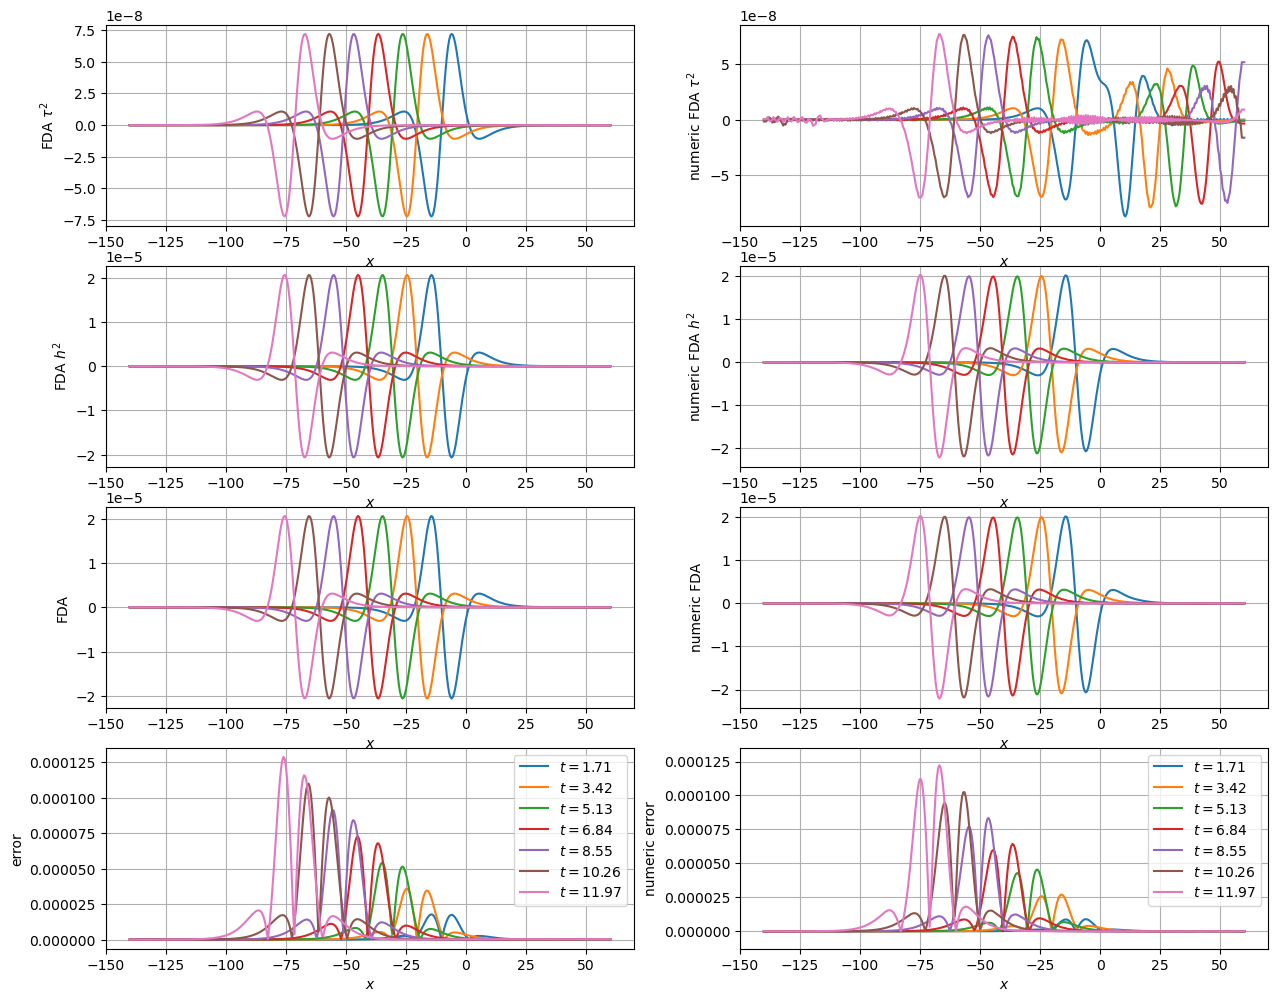

In [11]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solveZabuskyKruskal-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solveZabuskyKruskal-ex1.png")

In [12]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return -512*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3

In [13]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [14]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.001*dx
sol = solveZabuskyKruskal(ex2(dt, x, args), ex2(0., x, args), dt, dx, 600., 7)

dt/dx=0.00301
dt=0.000125, t1=600.0, шагов=4800000, вывод через 685714 шагов
_ _ _ _ _ _ 
CPU times: user 1min 40s, sys: 80.3 ms, total: 1min 40s
Wall time: 1min 41s


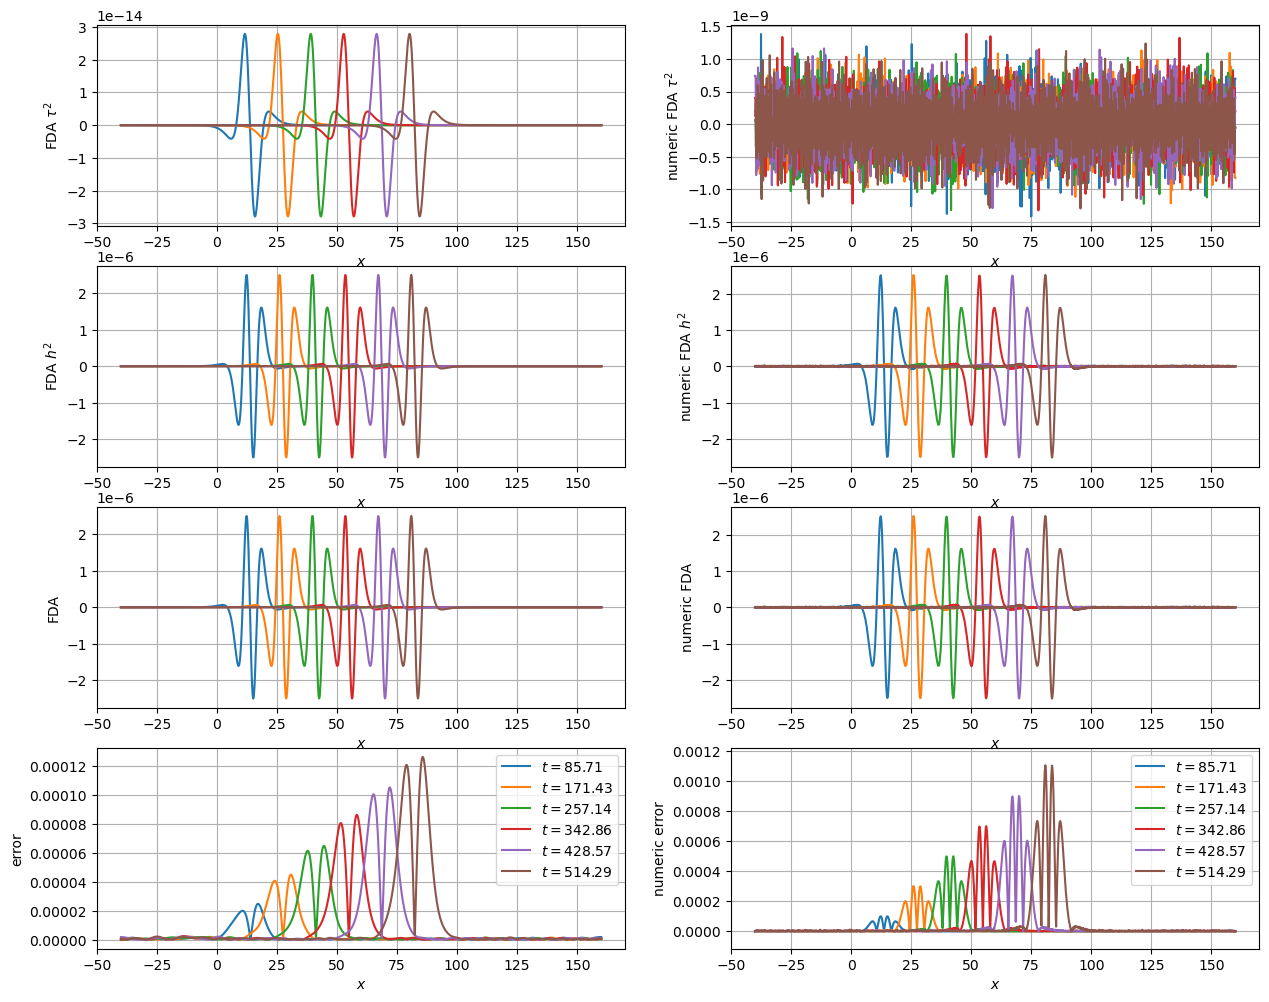

/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: overflow encountered in power
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)
/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: overflow encountered in multiply
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)
/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: invalid value encountered in divide
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)
/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: overflow encountered in power
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)
/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: overflow encountered in multiply
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)
/tmp/ipykernel_75730/3649750215.py:10: RuntimeWarning: invalid value encountered in divide
  return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)


In [15]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="")
draw1(sol, ex2, ex1FDAtau, ex2FDAh, 2, args, name="solveZabuskyKruskal-ex2.pdf")
draw1(sol, ex2, ex1FDAtau, ex2FDAh, 2, args, name="solveZabuskyKruskal-ex2.png")

In [16]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [17]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.001*dx
sol = solveZabuskyKruskal(ex3(dt, x, args), ex3(0., x, args), dt, dx, 100., 7)

dt/dx=0.00192
dt=0.00010000000000000143, t1=100.0, шагов=999999, вывод через 142857 шагов
_ _ _ _ _ _ 
CPU times: user 21.5 s, sys: 16.3 ms, total: 21.5 s
Wall time: 21.6 s


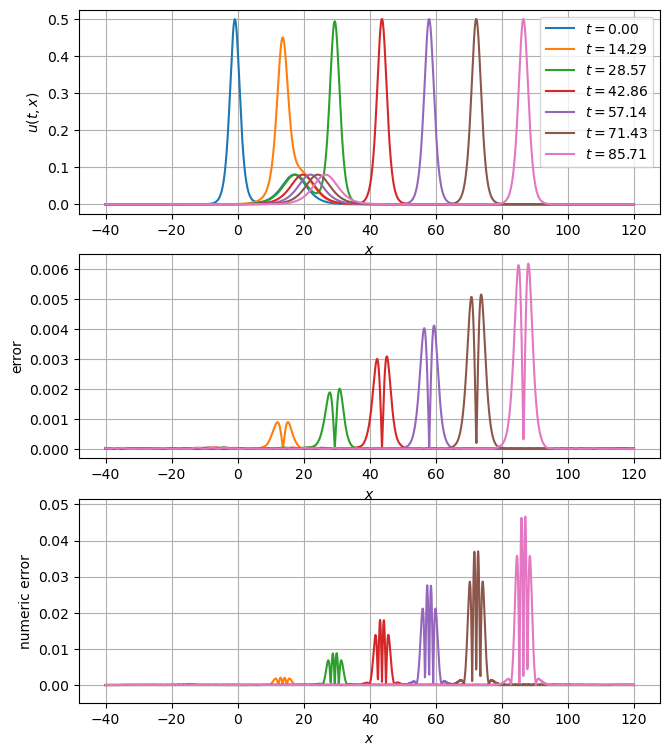

In [18]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solveZabuskyKruskal-ex3.pdf")
draw(sol, ex3, name="solveZabuskyKruskal-ex3.png")

we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{\alpha \tau}{h}u^{n}_{i}\left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\beta \tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right) \tag{1.80}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{2h^3}{3\sqrt{3}} \cong 0.384 h^3 \tag{1.81}
\end{equation}

In [19]:
def solve180(u0, u1, dt, dx, t1, n):
    """
    u0, u1 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    assert dt <= 2.*dx**3/(3*sqrt(3))
 
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = zeros_like(u0), [(0, u1.copy(), zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(2, int(t1/dt)):
        u[2:-2] = u1[2:-2] - 6*dt/dx*u0[2:-2]*(u0[3:-1] - u0[1:-3])\
                - dt/dx**3*(u0[4:] - 2.*u0[3:-1] + 2.*u0[1:-3] - u0[:-4])
        
        u[:2] = u[2]
        u[-2:] = u[-3]

        u0, u1, u = u, u0, u1
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u0.copy()]
            elif (i + 2) % k != 4:
                fi.append(u0.copy())
            else:
                fi.append(u0.copy())
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda2(fi)

                fi_h2 = 3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 9*fi_xx*fi_x/2
                fi_tau2 = fi_ttt/6
               
                fi_h2 *= dx**2
                fi_tau2 *= dt**2
                fda = fi_h2 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h2, fda, kf/pf*fda))
    print()
    return sol

In [20]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4\
        - 6*k**2*cosh(xi) + 21*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4
    
def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)

In [21]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 401

In [22]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.01*dx
sol = solve180(ex1(dt, x, args), ex1(0., x, args), dt, dx, 12, 7)

dt/dx=0.0481
dt=0.005, t1=12, шагов=2400, вывод через 342 шагов
_ _ _ _ _ _ _ 
CPU times: user 73.4 ms, sys: 4.08 ms, total: 77.5 ms
Wall time: 73.2 ms


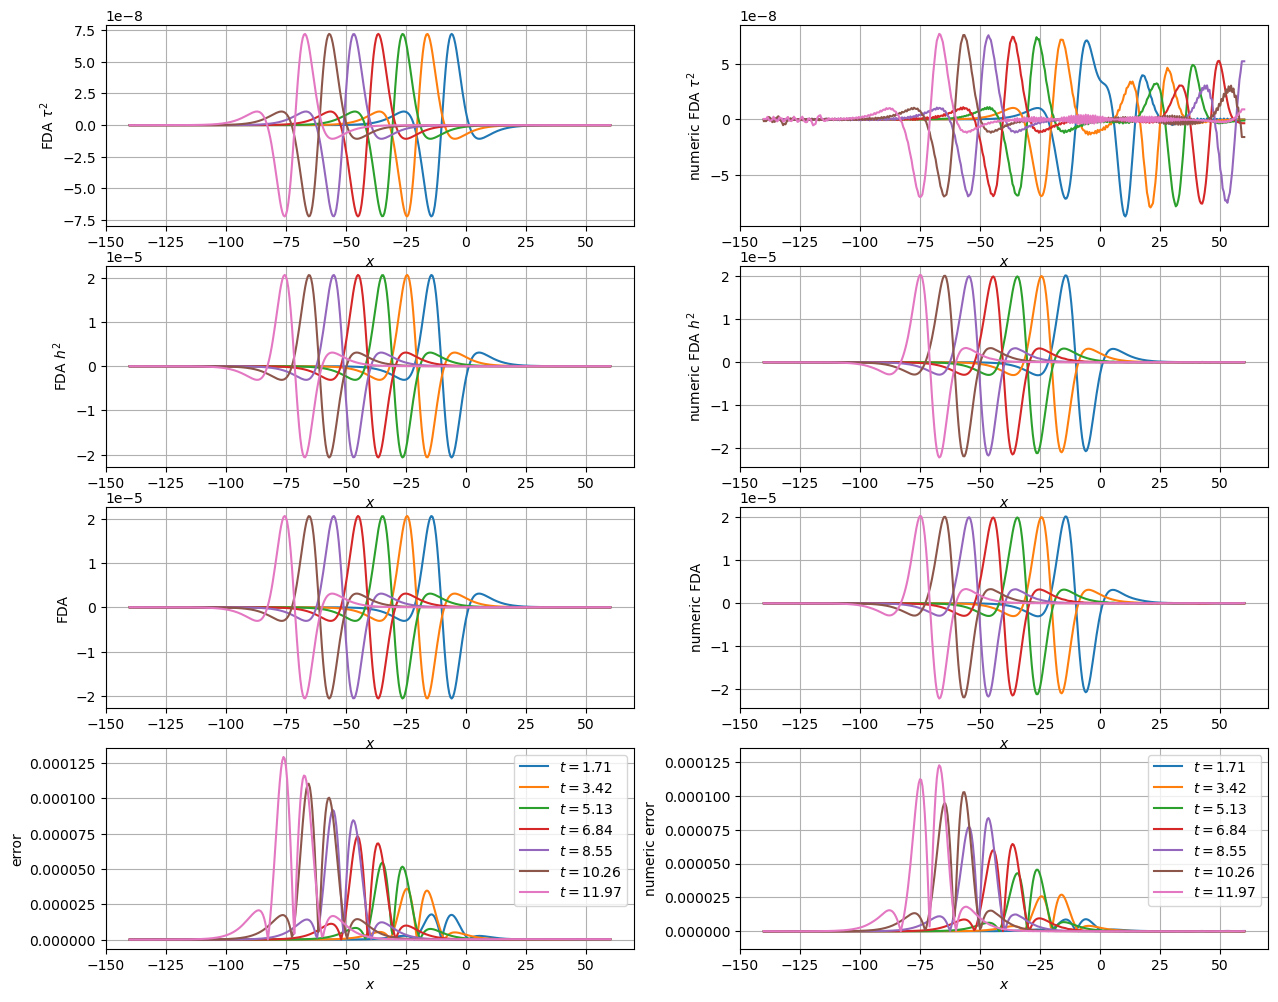

In [23]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve180-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve180-ex1.png")

In [24]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return -512*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3

In [25]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [26]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.001*dx
sol = solve180(ex2(dt, x, args), ex2(0., x, args), dt, dx, 600., 7)

dt/dx=0.00301
dt=0.000125, t1=600.0, шагов=4800000, вывод через 685714 шагов
_ _ _ _ _ _ 
CPU times: user 1min 26s, sys: 24.2 ms, total: 1min 26s
Wall time: 1min 26s


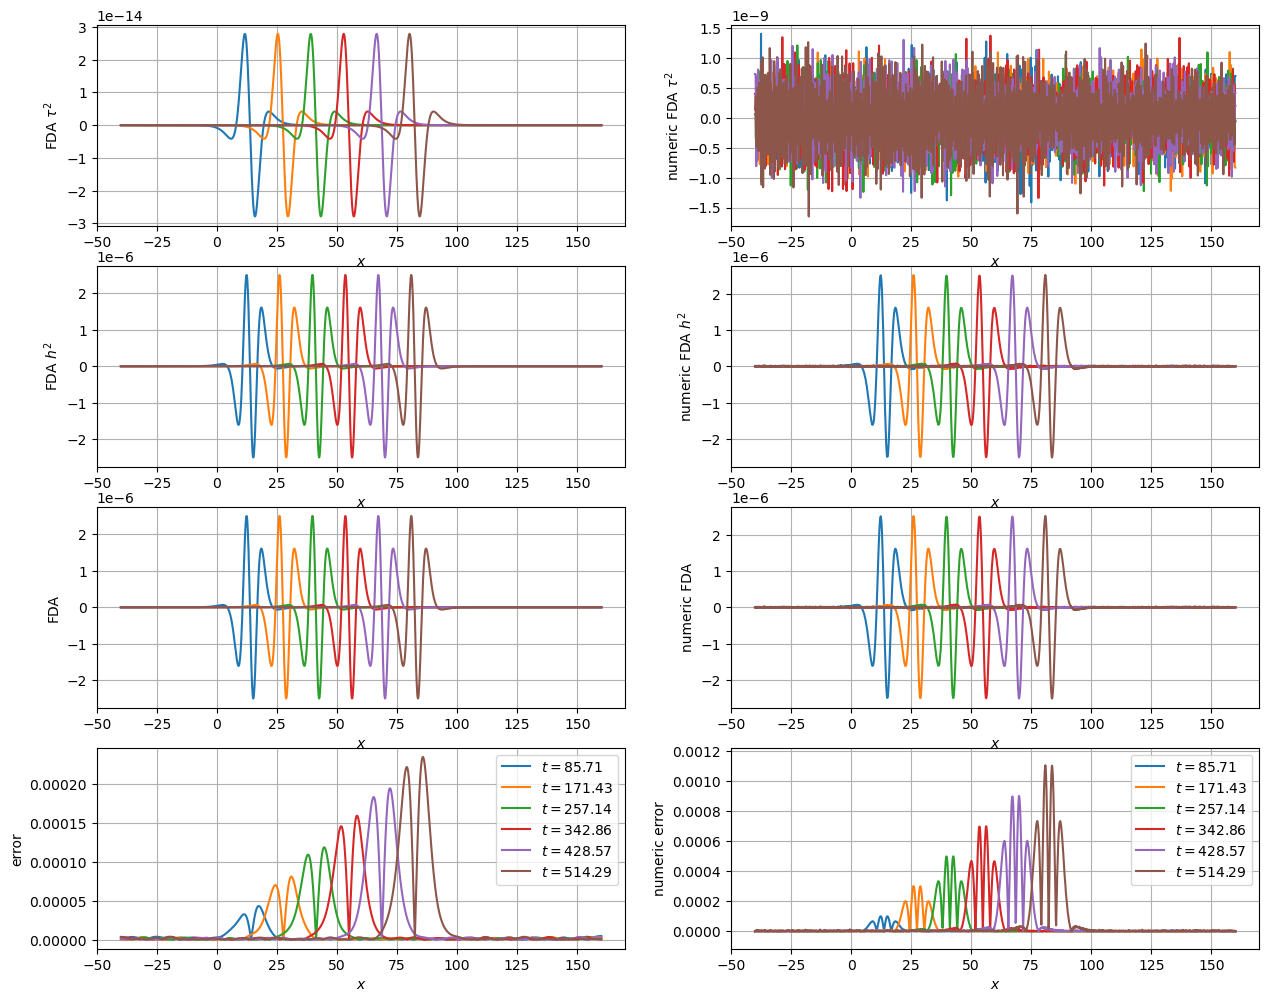

In [27]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve180-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve180-ex2.png")

In [28]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [29]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.001*dx
sol = solve180(ex3(dt, x, args), ex3(0., x, args), dt, dx, 100., 7)

dt/dx=0.00192
dt=0.00010000000000000143, t1=100.0, шагов=999999, вывод через 142857 шагов
_ _ _ _ _ _ 
CPU times: user 20.8 s, sys: 28 ms, total: 20.9 s
Wall time: 21 s


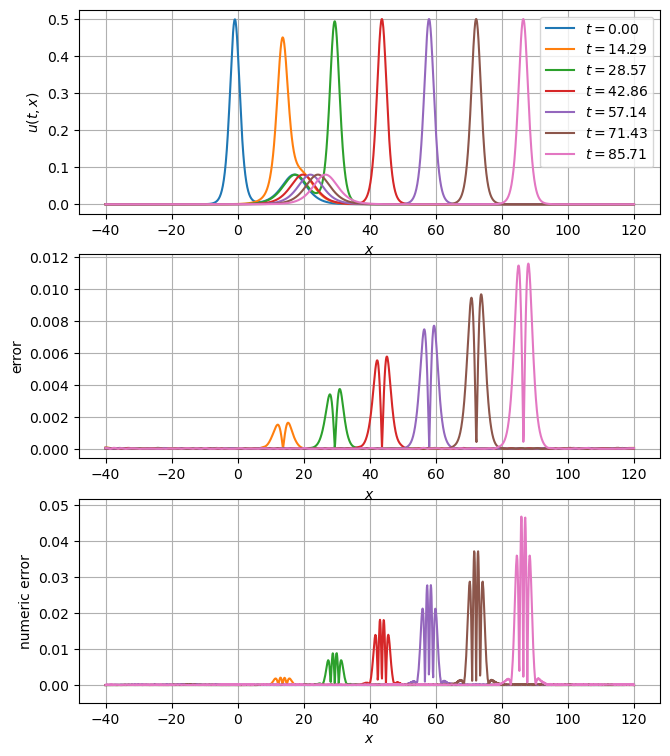

In [30]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve180-ex3.pdf")
draw(sol, ex3, name="solve180-ex3.png")

we explicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} 
    +\dfrac{\tau}{h}u^{n}_{i}\left(u^{n}_{i+2} - 8u^{n}_{i+1} + 8u^{n}_{i-1} - u^{n}_{i-2}\right)\\
 & + \dfrac{\tau}{4h^3}\left(u^{n}_{i+3} - 8u^{n}_{i+2} + 13u^{n}_{i+1} - 
                                   13u^{n}_{i-1} + 8u^{n}_{i-2} - u^{n}_{i-3}\right) \tag{1.82}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{108h^3}{(43 + 7\sqrt{73})\sqrt{10\sqrt{73} - 62}} \cong 0.216 h^3 \tag{1.83}
\end{equation}

In [31]:
def solve182(u0, u1, dt, dx, t1, n):
    """
    u0, u1 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    assert dt <= .216*dx**3
 
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = zeros_like(u0), [(0, u1.copy(), zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(2, int(t1/dt)):
        u[3:-3] = u1[3:-3] + dt/dx*u0[3:-3]*(u0[5:-1] - 8.*u0[4:-2]\
                    + 8.*u0[2:-4] - u0[1:-5]) + dt/(4.*dx**3)*(u0[6:]\
                    - 8.*u0[5:-1] + 13.*u0[4:-2] - 13.*u0[2:-4] + 8.*u0[1:-5] - u0[:-6])
        
#         u[0] = (400.*u[3] - 675.*u[4] + 432.*u[5] - 100.*u[6])/57.
#         u[1] = (300.*u[3] - 400.*u[4] + 225.*u[5] - 48.*u[6])/77.
#         u[2] = (48.*u[3] - 36.*u[4] + 16.*u[5] - 3.*u[6])/25.

#         u[-3] = (48.*u[-4] - 36.*u[-5] + 16.*u[-6] - 3.*u[-7])/25.
#         u[-2] = (300.*u[-4] - 400.*u[-5] + 225.*u[-6] - 48.*u[-7])/77.
#         u[-1] = (400.*u[-4] - 675.*u[-5] + 432.*u[-6] - 100.*u[-7])/57.
        
        u[:3] = u0[3]
        u[-3:] = u0[-4]

        u0, u1, u = u, u0, u1
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u0.copy()]
            elif (i + 2) % k != 4:
                fi.append(u0.copy())
            else:
                fi.append(u0.copy())
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda2(fi)

                fi_h4 = 27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2\
                    - 171*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 49*fi_tx*fi_x/20\
                    - 77*fi_t*fi_xx/20 - 21*fi_x**3/2
                fi_tau2 = fi_ttt/6
              
                fi_h4 *= dx**4
                fi_tau2 *= dt**2
                fda = fi_h4 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h4, fda, kf/pf*fda))
    print()
    return sol

In [32]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi)\
        + 3*D*sinh(4*xi) - 33761*k**2*sinh(xi)/4 + 12817*k**2*sinh(2*xi)/4\
        - 837*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)
    
def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)

In [33]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [34]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
print(f"dt/dx={.216*dx**2:.3g}")
dt = 0.001*dx
sol = solve182(ex1(dt, x, args), ex1(0., x, args), dt, dx, 12., 7)

dt/dx=0.00337
dt=0.000125, t1=12.0, шагов=96000, вывод через 13714 шагов
_ _ _ _ _ _ 
CPU times: user 2.88 s, sys: 3.94 ms, total: 2.88 s
Wall time: 2.89 s


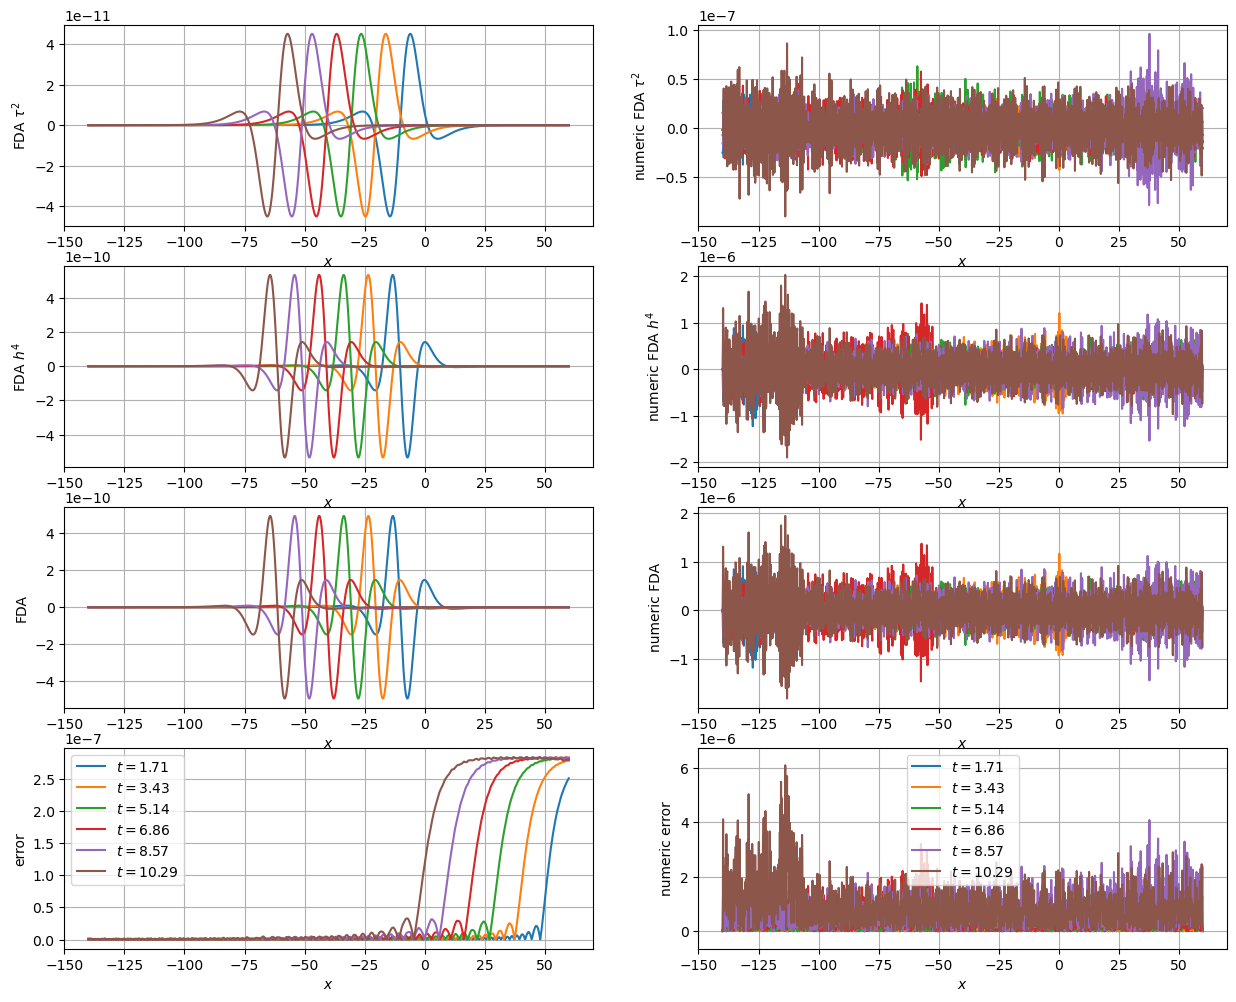

In [35]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve182-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve182-ex1.png")

In [36]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(27*tanh(xi)**4 - 33*tanh(xi)**2 + 7)*tanh(xi)/3

In [37]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
print(f"dt/dx={.216*dx**2:.3g}")
dt = 0.002*dx
sol = solve182(ex2(dt, x, args), ex2(0., x, args), dt, dx, 60., 7)

dt/dx=0.00337
dt=0.00025, t1=60.0, шагов=240000, вывод через 34285 шагов
_ _ _ _ _ _ _ 
CPU times: user 7.06 s, sys: 27.6 ms, total: 7.09 s
Wall time: 7.11 s


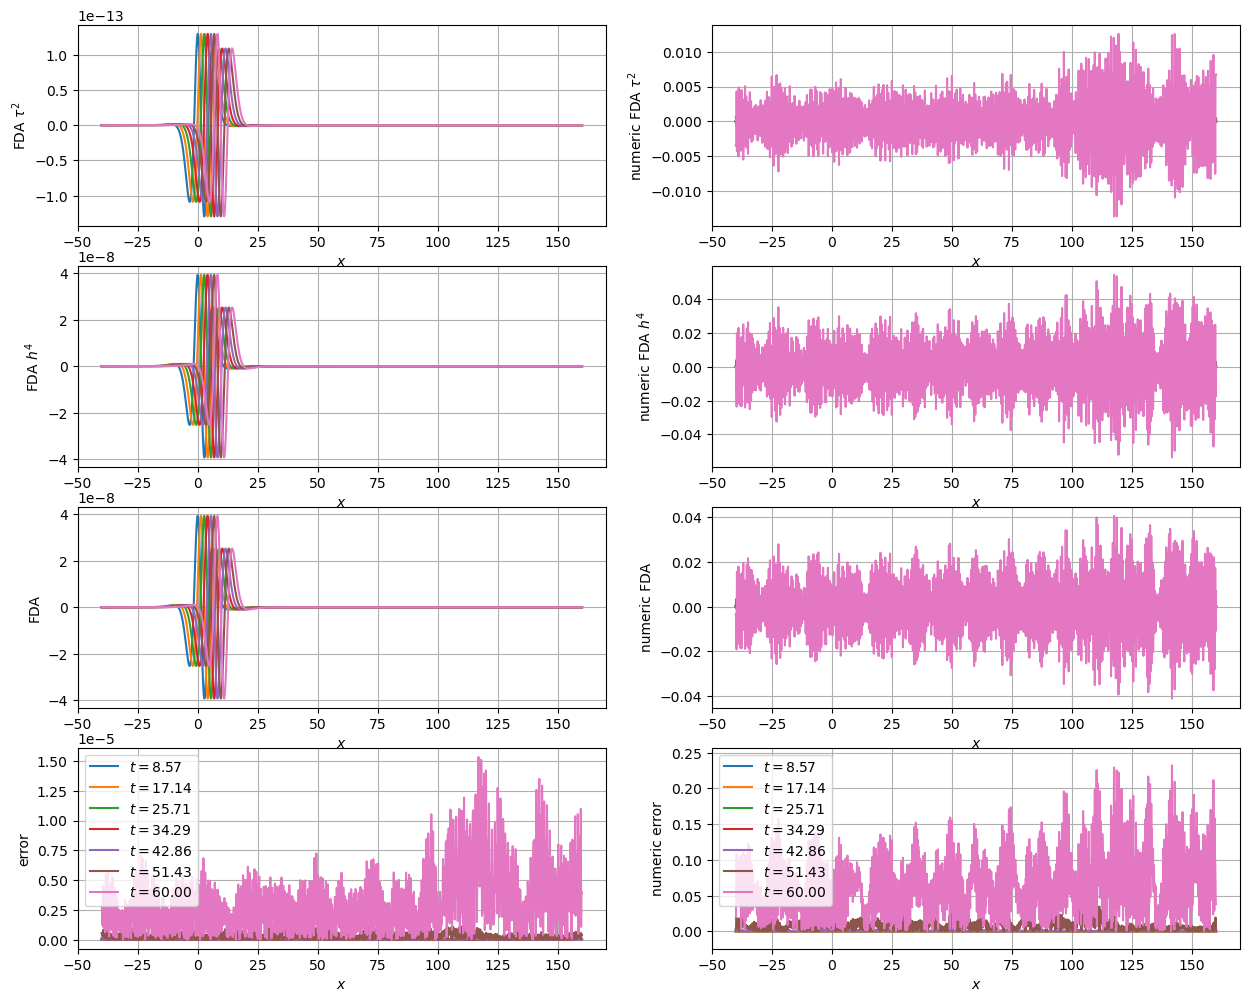

In [38]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve182-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve182-ex2.png")

In [39]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
print(f"dt/dx={dx**2/(3*sqrt(3)):.3g}")
dt = 0.003*dx
sol = solve180(ex3(dt, x, args), ex3(0., x, args), dt, dx, 100., 7)

dt/dx=0.00192
dt=0.00030000000000000426, t1=100.0, шагов=333333, вывод через 47619 шагов
_ _ _ _ _ _ 
CPU times: user 5.91 s, sys: 0 ns, total: 5.91 s
Wall time: 5.91 s


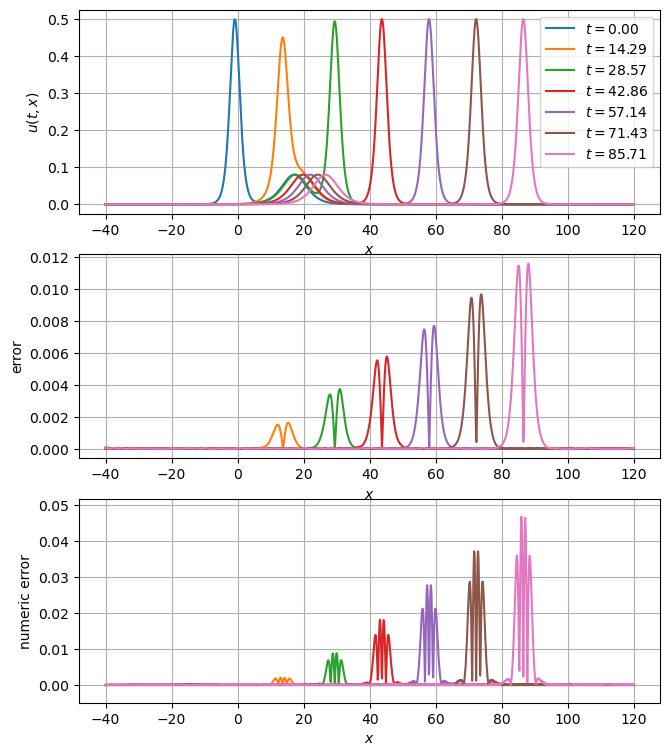

In [40]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve182-ex3.pdf")
draw(sol, ex3, name="solve182-ex3.png")

we Implicit   scheme with $O(\tau^2, h^2)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +\frac{3}{2h}\left[{u}_{j}^{n}\left({u}_{j+1}^{n+1} - {u}_{j-1}^{n+1}\right) +
              {u}_{j}^{n+1}\left({u}_{j+1}^{n} - {u}_{j-1}^{n}\right)\right] + \\
 +\frac{1}{4h^{3}}\left(\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)\right)=0.  \tag{1.96}
\end{multline*}

In [41]:
def solve196(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
        
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 5), dtype=int32)
    col = zeros((N, 5), dtype=int32)
    data = zeros((N, 5), dtype=float64)
    
    # столбец свободных членов
    b = zeros(N, dtype=float64)
    
    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(2, N-2):
        col[i] = i-2, i-1, i, i+1, i+2

    # граничные условия в точке x[0]
    col[0, :2] = 0, 2
    data[0, :2] = -1., 1.
    # граничные условия в точке x[1]
    col[1, :2] = 1, 2
    data[1, :2] = -1., 1.
    # граничные условия в точке x[-2]
    col[-2, :2] = N-2, N-3
    data[-2, :2] = -1., 1.
    # граничные условия в точке x[-1]
    col[-1, :2] = N-1, N-3
    data[-1, :2] = -1., 1.
        
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[2:-2, 0] = -dt/(4*dx**3)
    data[2:-2, 4] =  dt/(4*dx**3)  
    
    
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0, u0, zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(1, int(t1/dt)):
        # задание переменных элементов матрицы
        # (ответственны за нелинейные члены)
        data[2:-2, 1] = dt/dx*(-3*u[2:-2]/2. + 1./(2.*dx**2))
        data[2:-2, 2] = 1. + dt*3*(u[3:-1] - u[1:-3])/(2.*dx)
        data[2:-2, 3] = dt/dx*( 3*u[2:-2]/2. - 1./(2.*dx**2))

        # вычисление правой части
        b[2:-2] = u[2:-2] - dt*(u[4:] - 2.*u[3:-1] + 2.*u[1:-3] - u[:-4])/(4.*dx**3)
        
        # решение разреженной системы линейных уравнений
        v = spsolve(csr_matrix((data.reshape(N*5),\
            (row.reshape(N*5), col.reshape(N*5))),\
            shape=(N, N)), b)
        u = v
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u]
            elif (i + 2) % k != 4:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda2(fi)
                
                fi_h2 = 3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 9*fi_xx*fi_x/2
                fi_tau2 = -fi_ttt/12 - 3*fi_tx*fi_t
                
                fi_h2 *= dx**2
                fi_tau2 *= dt**2
                fda = fi_h2 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h2, fda, kf/pf*fda))
    print()
    return sol

In [42]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(4*D*sinh(xi)**2 - 16*D*cosh(xi) - 16*D + k**2*sinh(xi)**2\
        - 24*k**2*cosh(xi) + 42*k**2)*sinh(xi)/(4*(cosh(xi) + 1)**4)
    
def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(6*D + k**2)**2*(36*k**2*(-sinh(xi)**2 + cosh(xi) + 1)\
        + (6*D + k**2)*(cosh(xi) - 5)*(cosh(xi) + 1)**2)*sinh(xi)/(12*(cosh(xi) + 1)**5)

In [43]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [44]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve196(ex1(0., x, args), dt, dx, 12., 7)

dt=0.0625, t1=12.0, шагов=192, вывод через 27 шагов
_ _ _ _ _ _ _ 
CPU times: user 312 ms, sys: 3.93 ms, total: 316 ms
Wall time: 346 ms


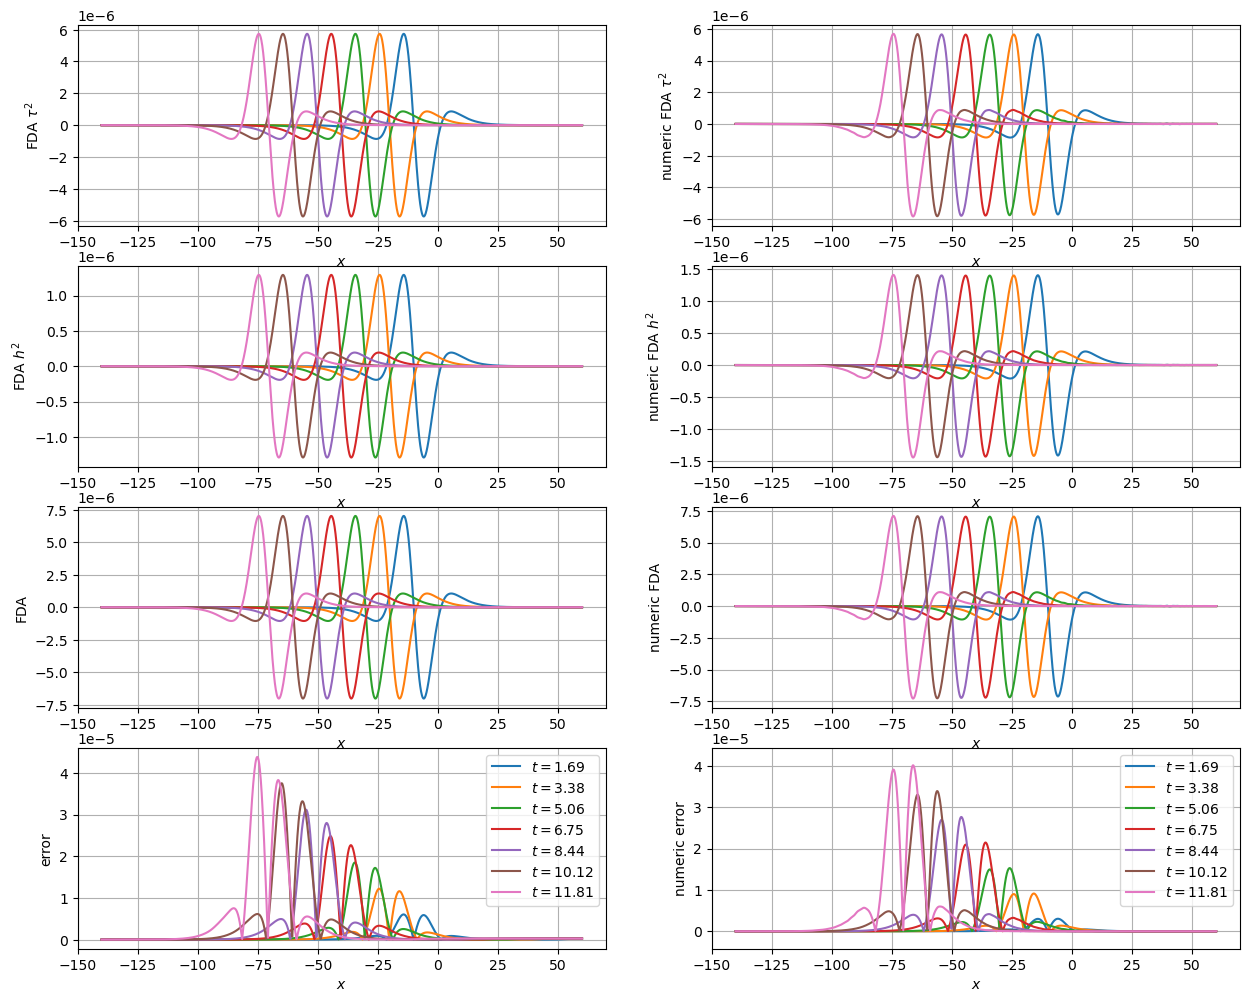

In [45]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve196-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve196-ex1.png")

In [46]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)\
        *(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)\
        *(27*tanh(xi)**4 - 33*tanh(xi)**2 + 7)*tanh(xi)/3

In [47]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve196(ex2(0., x, args), dt, dx, 600., 7)

dt=0.0625, t1=600.0, шагов=9600, вывод через 1371 шагов
_ _ _ _ _ _ _ 
CPU times: user 14.3 s, sys: 23.6 ms, total: 14.4 s
Wall time: 14.4 s


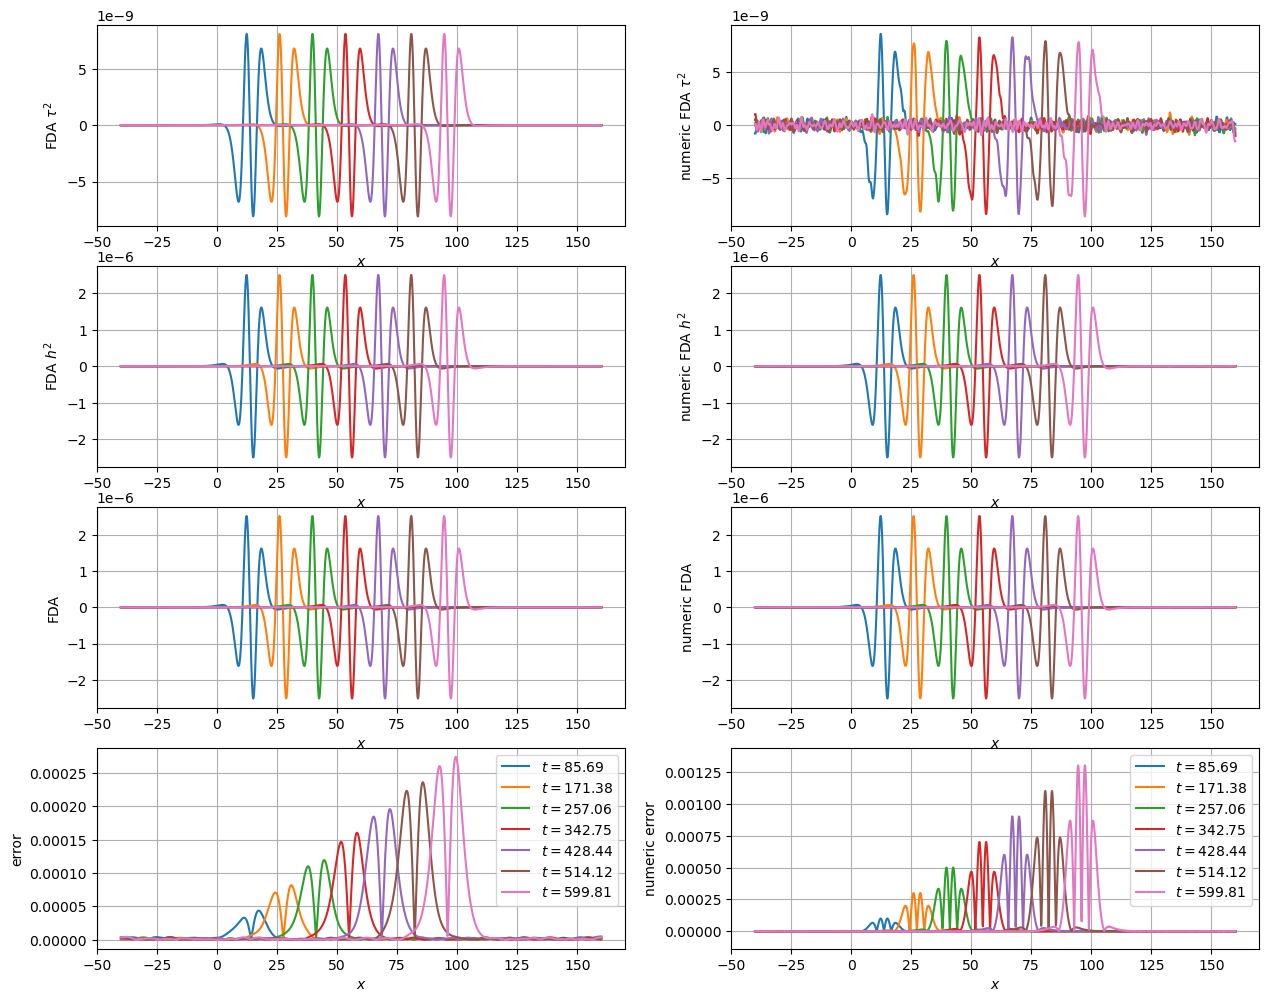

In [48]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve196-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve196-ex2.png")

In [49]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve196(ex3(0., x, args), dt, dx, 100., 7)

dt=0.05000000000000071, t1=100.0, шагов=1999, вывод через 285 шагов
_ _ _ _ _ _ _ 
CPU times: user 3.13 s, sys: 8.05 ms, total: 3.13 s
Wall time: 3.15 s


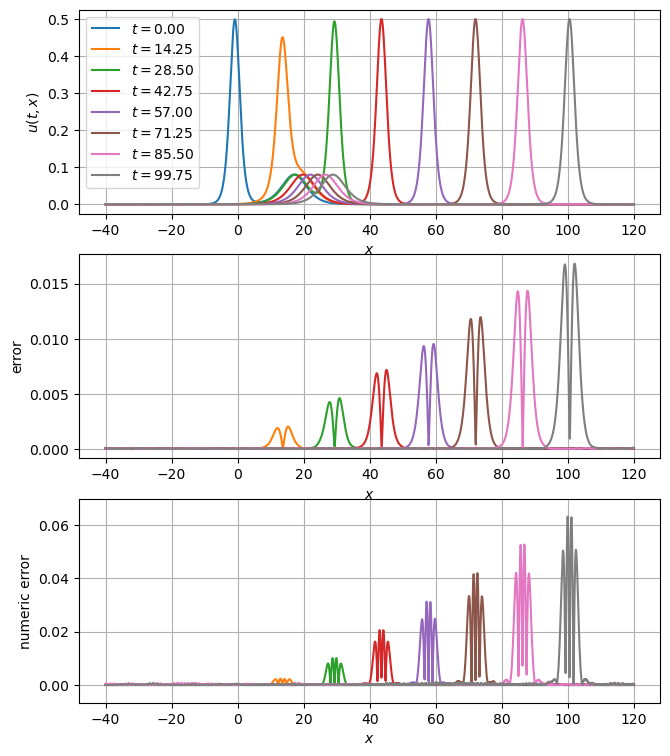

In [50]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve196-ex3.pdf")
draw(sol, ex3, name="solve196-ex3.png")

we Implicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 =\frac{3}{2h}\left[{u}_{j}^{n}\left({u}_{j+2}^{n+1} - 8{u}_{j+1}^{n+1} + 8{u}_{j-1}^{n+1} - {u}_{j-2}^{n+1}\right) 
              + {u}_{j}^{n+1}\left({u}_{j+2}^{n} - 8{u}_{j+1}^{n} + 8{u}_{j-1}^{n} - {u}_{j-2}^{n}\right)\right] + \\
 +\frac{1}{4h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) +
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right).  \tag{1.84}
\end{multline*}

In [51]:
def solve184(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
        
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 7), dtype=int32)
    col = zeros((N, 7), dtype=int32)
    data = zeros((N, 7), dtype=float64)
    
    # столбец свободных членов
    b = zeros(N, dtype=float64)
    
    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(3, N-3):
        col[i] = i-3, i-2, i-1, i, i+1, i+2, i+3

    # граничные условия в точке x[0]
    col[0, :2] = 0, 3
    data[0, :2] = -1., 1.
    # граничные условия в точке x[1]
    col[1, :2] = 1, 3
    data[1, :2] = -1., 1.
    # граничные условия в точке x[2]
    col[2, :2] = 2, 3
    data[2, :2] = -1., 1.
    # граничные условия в точке x[-3]
    col[-3, :2] = N-3, N-4
    data[-3, :2] = -1., 1.
    # граничные условия в точке x[-2]
    col[-2, :2] = N-2, N-4
    data[-2, :2] = -1., 1.
    # граничные условия в точке x[-1]
    col[-1, :2] = N-1, N-4
    data[-1, :2] = -1., 1.
        
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[3:-3, 0] =  dt/(16*dx**3)
    data[3:-3, 6] = -dt/(16*dx**3)    

    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0, u0, zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(1, int(t1/dt)):
        # задание переменных элементов матрицы
        # (ответственны за нелинейные члены)
        data[3:-3, 1] = dt/dx*(   u[3:-3]/4 - 1/(2*dx**2))
        data[3:-3, 2] = dt/dx*(-2*u[3:-3] + 13/(16*dx**2))
        data[3:-3, 3] = 1. - dt/(4.*dx)*(u[5:-1] - 8.*u[4:-2] + 8.*u[2:-4] - u[1:-5])
        data[3:-3, 4] = dt/dx*( 2*u[3:-3] - 13/(16*dx**2))
        data[3:-3, 5] = dt/dx*(  -u[3:-3]/4 + 1/(2*dx**2))

        # вычисление правой части
        b[3:-3] = u[3:-3] + dt*(\
            + (u[6:] - 8.*u[5:-1] + 13.*u[4:-2] -\
                13.*u[2:-4] + 8.*u[1:-5] - u[:-6])/(16.*dx**2))    

        # решение разреженной системы линейных уравнений
        v = spsolve(csr_matrix((data.reshape(N*7),\
            (row.reshape(N*7), col.reshape(N*7))),\
            shape=(N, N)), b)
        u = v
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u]
            elif (i + 2) % k != 4:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda4(fi)
                
                fi_h4 = 27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2\
                    - 171*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 49*fi_tx*fi_x/20\
                    - 77*fi_t*fi_xx/20 - 21*fi_x**3/2
                fi_tau2 = -fi_ttt/12 - 3*fi_tx*fi_t
                
                fi_h4 *= dx**4
                fi_tau2 *= dt**2
                fda = fi_h4 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h4, fda, kf/pf*fda))
    print()
    return sol

In [52]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi)\
        + 3*D*sinh(4*xi) - 33761*k**2*sinh(xi)/4 + 12817*k**2*sinh(2*xi)/4\
        - 837*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)
    
def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(6*D + k**2)**2*(36*k**2*(-sinh(xi)**2 + cosh(xi) + 1)\
        + (6*D + k**2)*(cosh(xi) - 5)*(cosh(xi) + 1)**2)*sinh(xi)/(12*(cosh(xi) + 1)**5)

In [53]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [54]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
dt = 0.05*dx
sol = solve184(ex1(0., x, args), dt, dx, 12., 7)

dt=0.00625, t1=12.0, шагов=1920, вывод через 274 шагов
_ _ _ _ _ _ 
CPU times: user 4.01 s, sys: 12.1 ms, total: 4.02 s
Wall time: 4.05 s


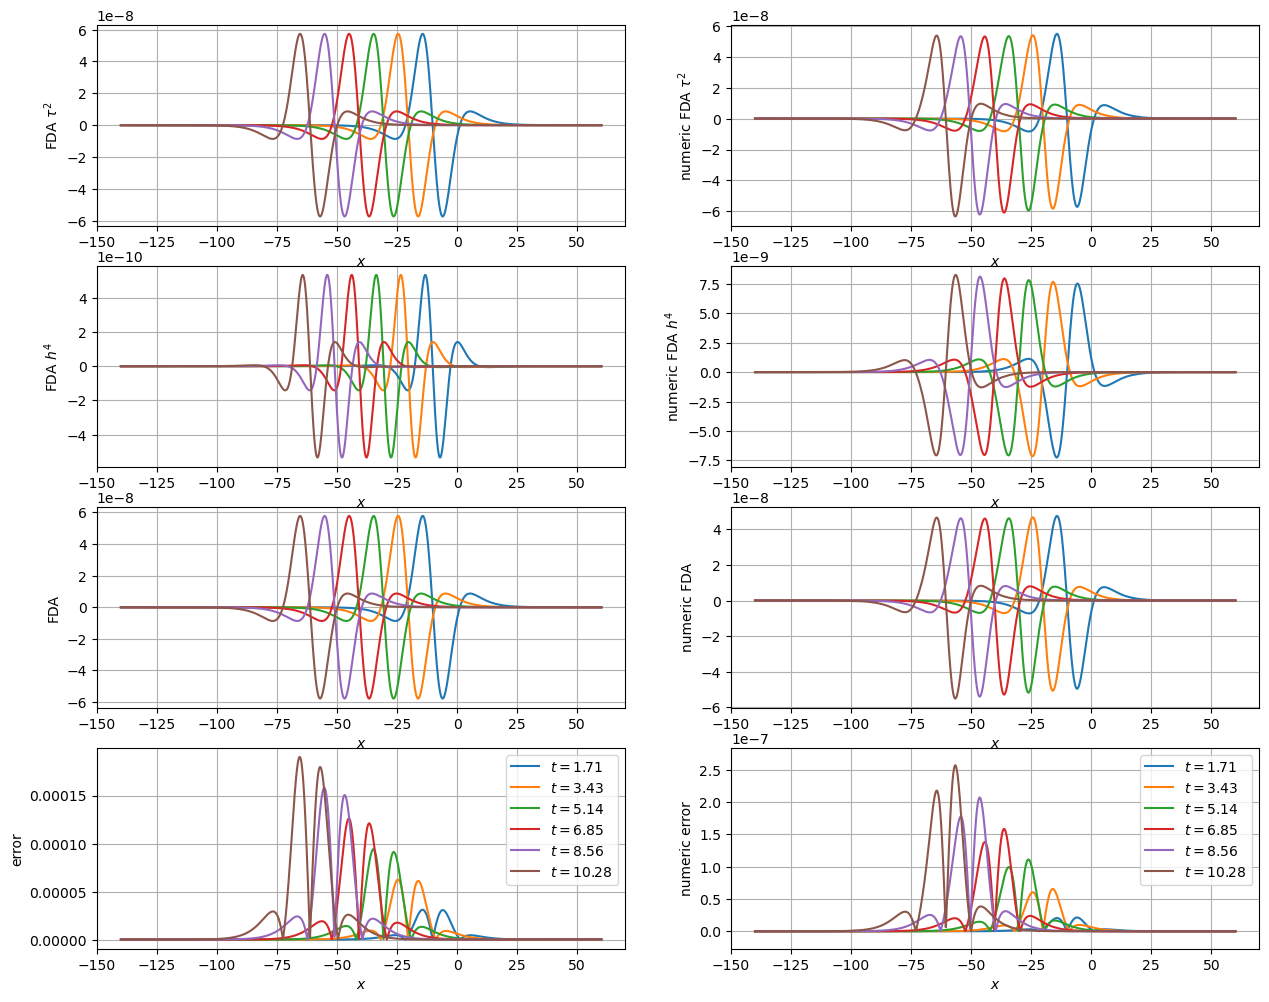

In [55]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve184-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve184-ex1.png")

In [56]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return -32*k**9*(tanh(xi) - 1)*(tanh(xi) + 1)*(1935*tanh(xi)**6\
        - 3780*tanh(xi)**4 + 2184*tanh(xi)**2 - 332)*tanh(xi)/15
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(27*tanh(xi)**4 - 33*tanh(xi)**2 + 7)*tanh(xi)/3

In [57]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 801

In [58]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve184(ex2(0., x, args), dt, dx, 600., 7)

dt=0.125, t1=600.0, шагов=4800, вывод через 685 шагов
_ _ _ _ _ _ _ 
CPU times: user 5.64 s, sys: 92 µs, total: 5.64 s
Wall time: 5.66 s


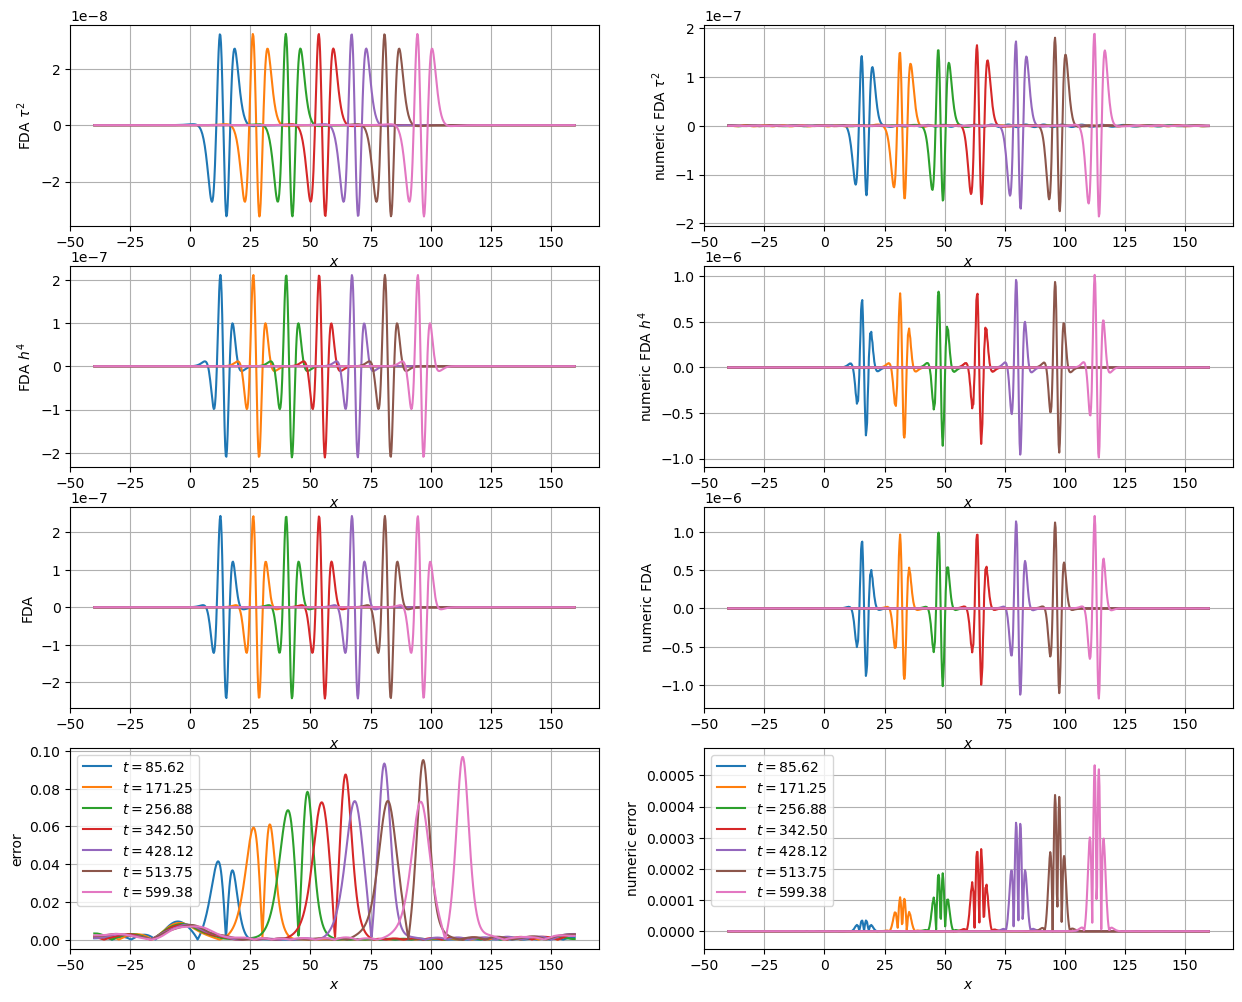

In [59]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve184-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve184-ex2.png")

In [60]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [61]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
dt = 0.05*dx
sol = solve184(ex3(0., x, args), dt, dx, 100., 7)

dt=0.005000000000000071, t1=100.0, шагов=19999, вывод через 2857 шагов
_ _ _ _ _ _ 
CPU times: user 37.8 s, sys: 31.7 ms, total: 37.8 s
Wall time: 37.9 s


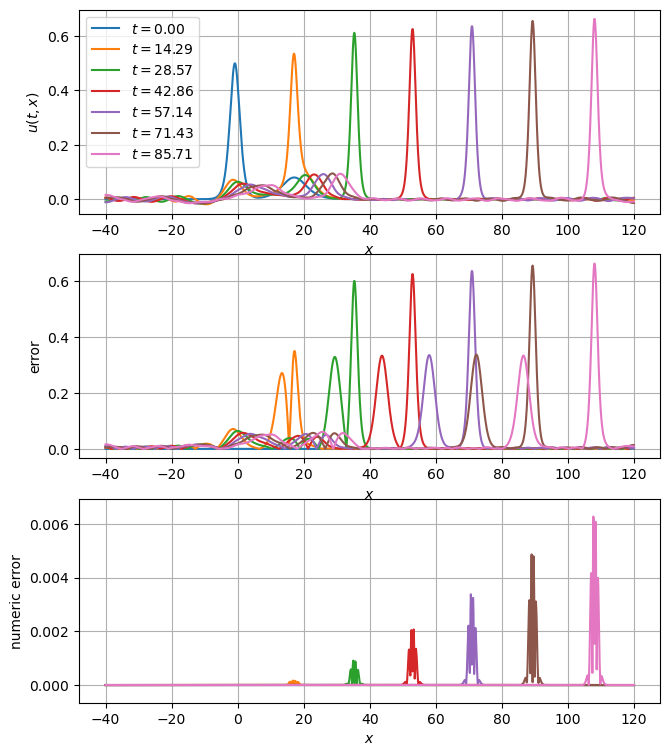

In [62]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve184-ex3.pdf")
draw(sol, ex3, name="solve184-ex3.png")

В результате получим следующую разностную схему для уравнения~(1.18), 
аналогичную схеме Кранка--Николсона для уравнения теплопроводности
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +3\frac{\left({u^2}_{j+1}^{n+1} - {u^2}_{j-1}^{n+1}\right) +
              \left({u^2}_{j+1}^{n} - {u^2}_{j-1}^{n}\right)}{4h} + \\
 + \frac{\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)}{4h^{3}}=0.
\end{multline*}

In [63]:
def solve5(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 5), dtype=int32)
    col = zeros((N, 5), dtype=int32)
    data = zeros((N, 5), dtype=float64)

    # столбец свободных членов
    b = zeros(N, dtype=float64)

    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(2, N-2):
        col[i] = i-2, i-1, i, i+1, i+2

    # граничные условия в точке x[0]
    col[0, :2] = 0, 2
    data[0, :2] = -1., 1.
    # граничные условия в точке x[1]
    col[1, :2] = 1, 2
    data[1, :2] = -1., 1.
    # граничные условия в точке x[-2]
    col[-2, :2] = N-2, N-3
    data[-2, :2] = -1., 1.
    # граничные условия в точке x[-1]
    col[-1, :2] = N-1, N-3
    data[-1, :2] = -1., 1.
    
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[2:-2, 0] = -dt/(4*dx**3)
    data[2:-2, 2] = 1.
    data[2:-2, 4] =  dt/(4*dx**3)
    
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0, u0, zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(1, int(t1/dt)):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[2:-2, 1] = dt/dx*(-3.*v[1:-3]/2. + 2./(4.*dx**2))
            data[2:-2, 3] = dt/dx*( 3.*v[3:-1]/2. - 2./(4.*dx**2))

            # вычисление правой части
            b[2:-2] = u[2:-2] + dt/dx*(\
                + 3.*(v[3:-1]**2 - v[1:-3]**2)/4.\
                - 3.*(u[3:-1]**2 - u[1:-3]**2)/4.\
                - (u[4:] - 2.*u[3:-1] + 2.*u[1:-3] - u[:-4])/(4.*dx**2))
             
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(N*5),\
                (row.reshape(N*5), col.reshape(N*5))),\
                shape=(N, N)), b)
            # условие выхода из простой итерации
            f = norm(v - v1)/(1 + norm(v1)) > 1.e-12
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u]
            elif (i + 2) % k != 4:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda2(fi)

                fi_h2 = 3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 3*fi_xx*fi_x/2
                fi_tau2 = -fi_ttt/12

                fi_h2 *= dx**2
                fi_tau2 *= dt**2
                fda = fi_h2 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h2, fda, kf/pf*fda))
    print()
    return sol

In [64]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4\
        - 3*k**2*cosh(xi) + 9*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4

def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**5*(6*D + k**2)**3*(-6*sinh(xi)**2 + 5*cosh(xi)**2\
        + 4*cosh(xi) - 1)*sinh(xi)/(12*(cosh(xi) + 1)**4)

In [65]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [66]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve5(ex1(0., x, args), dt, dx, 12., 7)

dt=0.0625, t1=12.0, шагов=192, вывод через 27 шагов
_ _ _ _ _ _ _ 
CPU times: user 1.05 s, sys: 3.99 ms, total: 1.06 s
Wall time: 1.1 s


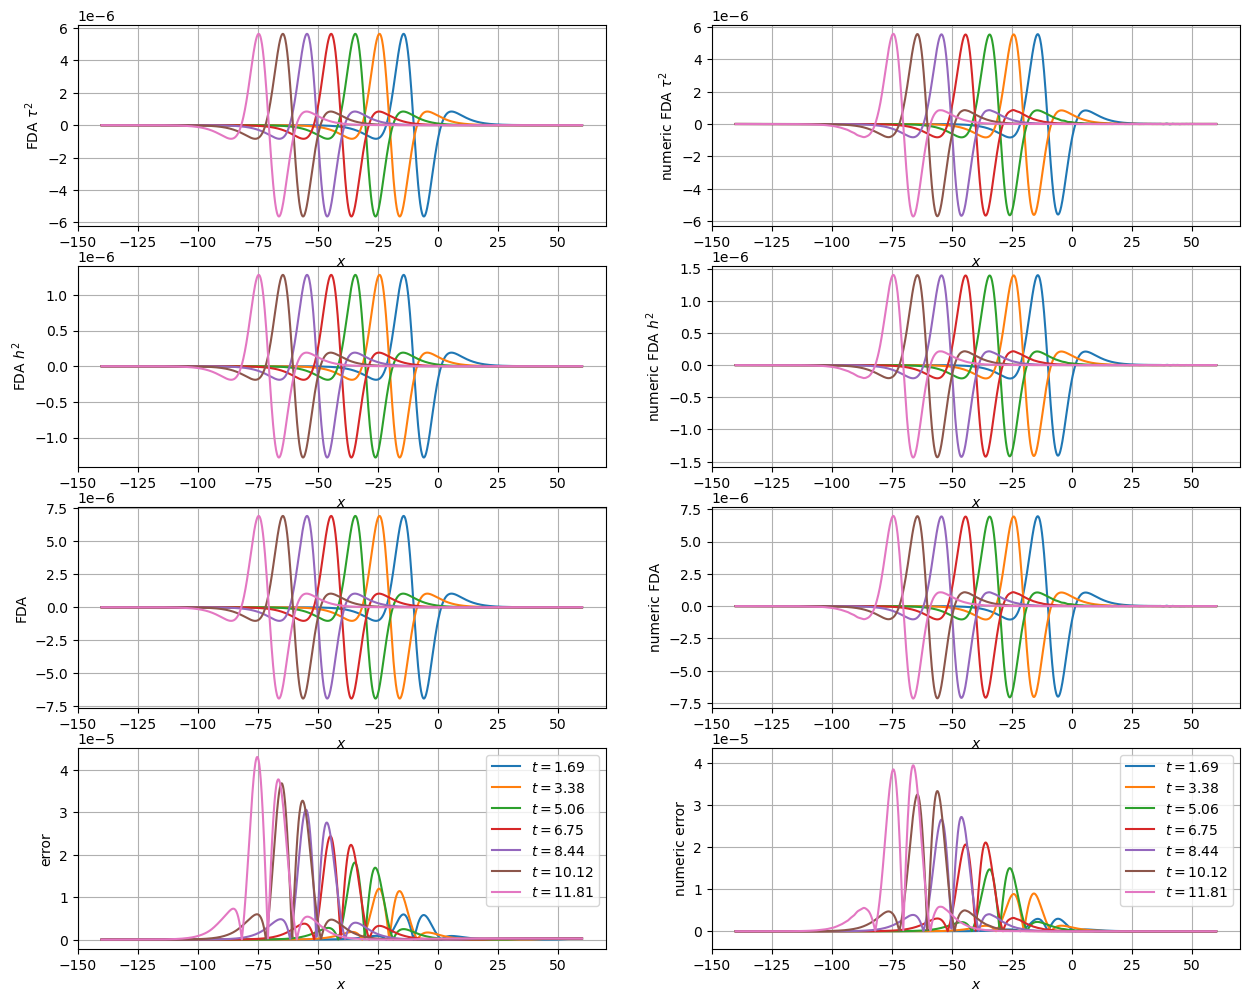

In [67]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve5-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 2, args, name="solve5-ex1.png")

In [68]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)\
        *(15*tanh(xi)**4 - 16*tanh(xi)**2 + 3)*tanh(xi)
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)\
        *(3*tanh(xi)**2 - 2)*tanh(xi)/3

In [69]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve5(ex2(0., x, args), dt, dx, 600., 7)

dt=0.0625, t1=600.0, шагов=9600, вывод через 1371 шагов
_ _ _ _ _ _ _ 
CPU times: user 50.7 s, sys: 199 ms, total: 50.9 s
Wall time: 51.8 s


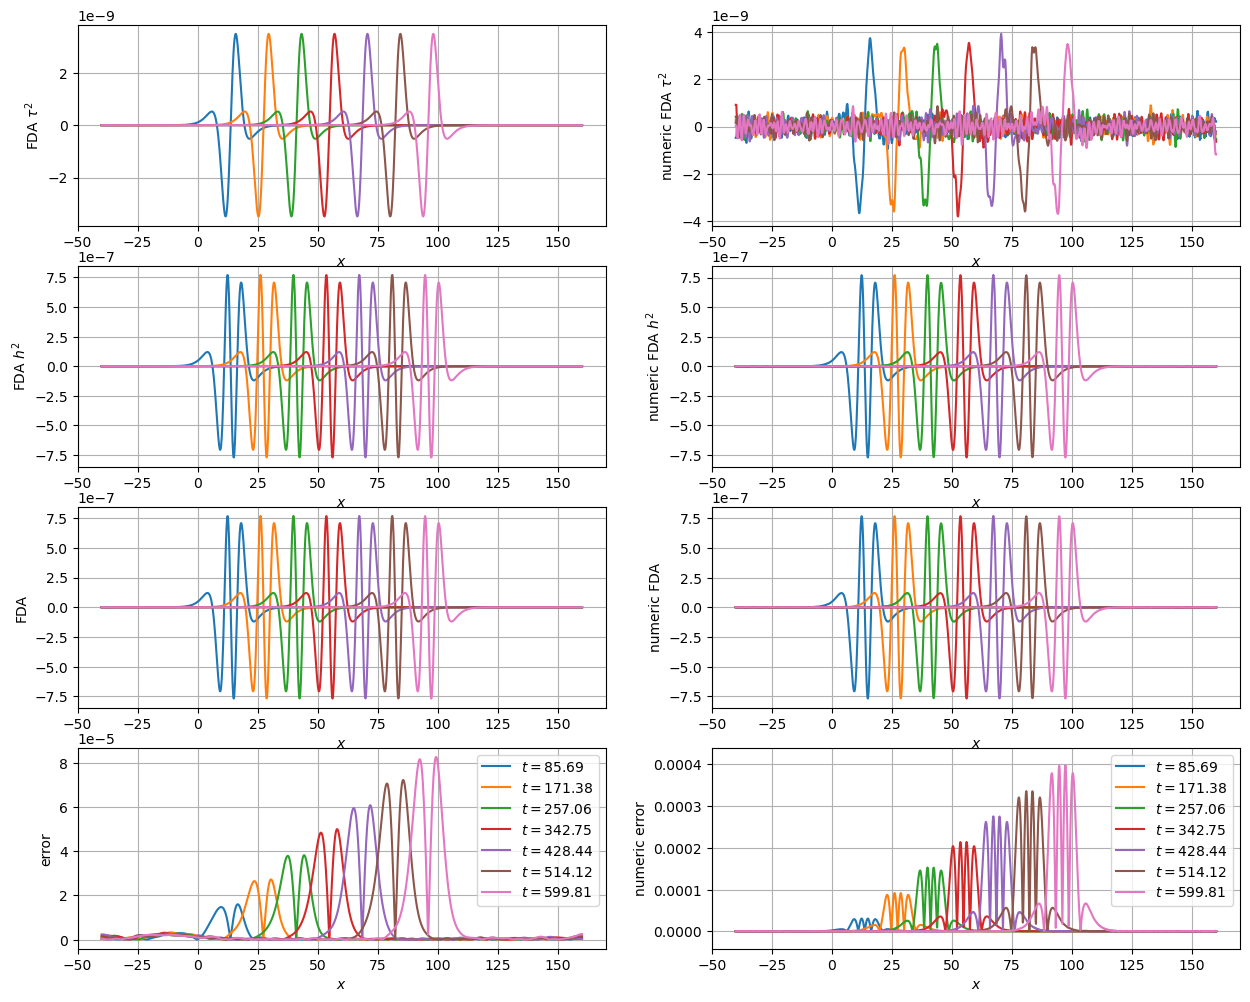

In [70]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve5-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 2, args, name="solve5-ex2.png")

In [71]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve5(ex3(0., x, args), dt, dx, 100., 7)

dt=0.05000000000000071, t1=100.0, шагов=1999, вывод через 285 шагов
_ _ _ _ _ _ _ 
CPU times: user 14.4 s, sys: 19 ms, total: 14.4 s
Wall time: 14.9 s


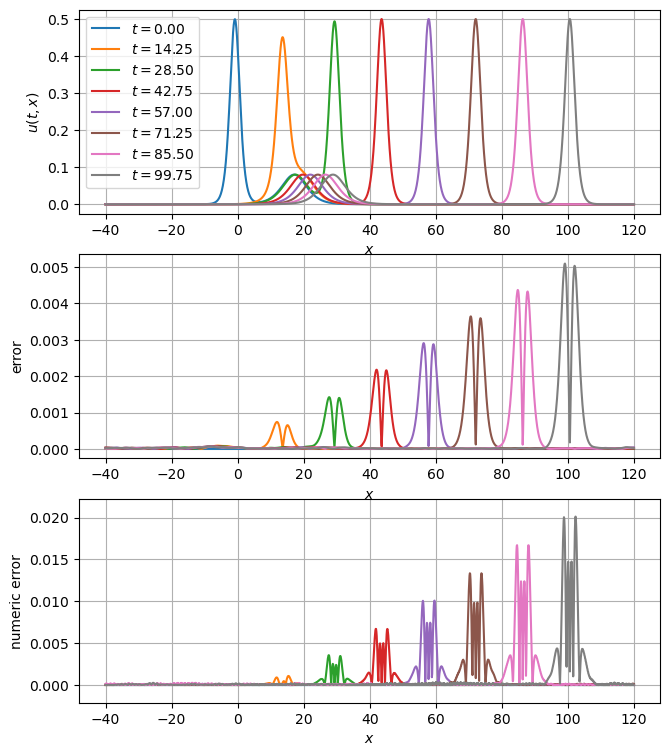

In [72]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve5-ex3.pdf")
draw(sol, ex3, name="solve5-ex3.png")

Наша $O(\tau^2, h^4)$:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 - \frac{3}{24h}\left(\left({u^2}_{j+2}^{n+1} - 8{u^2}_{j+1}^{n+1} + 8{u^2}_{j-1}^{n+1} - {u^2}_{j-2}^{n+1}\right) 
              + \left({u^2}_{j+2}^{n} - 8{u^2}_{j+1}^{n} + 8{u^2}_{j-1}^{n} - {u^2}_{j-2}^{n}\right)\right) + \\
 - \frac{1}{16h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) + \right. \\ \left.
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right)=0
\end{multline*}

In [73]:
def solve7(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
        
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 7), dtype=int32)
    col = zeros((N, 7), dtype=int32)
    data = zeros((N, 7), dtype=float64)
    
    # столбец свободных членов
    b = zeros(N, dtype=float64)
    
    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(3, N-3):
        col[i] = i-3, i-2, i-1, i, i+1, i+2, i+3

    # граничные условия в точке x[0]
    col[0, :2] = 0, 3
    data[0, :2] = -1., 1.
    # граничные условия в точке x[1]
    col[1, :2] = 1, 3
    data[1, :2] = -1., 1.
    # граничные условия в точке x[2]
    col[2, :2] = 2, 3
    data[2, :2] = -1., 1.
    # граничные условия в точке x[-3]
    col[-3, :2] = N-3, N-4
    data[-3, :2] = -1., 1.
    # граничные условия в точке x[-2]
    col[-2, :2] = N-2, N-4
    data[-2, :2] = -1., 1.
    # граничные условия в точке x[-1]
    col[-1, :2] = N-1, N-4
    data[-1, :2] = -1., 1.
        
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[3:-3, 0] =  dt/(16*dx**3)
    data[3:-3, 3] = 1.
    data[3:-3, 6] = -dt/(16*dx**3)    

    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0, u0, zeros_like(u0),\
                    zeros_like(u0), zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf, kf = 0., 0.
    for i in range(1, int(t1/dt)):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[3:-3, 1] = dt/dx*(   v[1:-5]/4 - 1/(2*dx**2))
            data[3:-3, 2] = dt/dx*(-2*v[2:-4] + 13/(16*dx**2))
            data[3:-3, 4] = dt/dx*( 2*v[4:-2] - 13/(16*dx**2))
            data[3:-3, 5] = dt/dx*(  -v[5:-1]/4 + 1/(2*dx**2))

            # вычисление правой части
            b[3:-3] = u[3:-3] + dt/dx*(\
                - (v[5:-1]**2 - 8.*v[4:-2]**2 + 8.*v[2:-4]**2 - v[1:-5]**2)/8.\
                + (u[5:-1]**2 - 8.*u[4:-2]**2 + 8.*u[2:-4]**2 - u[1:-5]**2)/8.\
                + (u[6:] - 8.*u[5:-1] + 13.*u[4:-2] -\
                    13.*u[2:-4] + 8.*u[1:-5] - u[:-6])/(16.*dx**2))

            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(N*7),\
                (row.reshape(N*7), col.reshape(N*7))),\
                shape=(N, N)), b)
            # условие выхода из простой итерации
            f = norm(v - v1)/(1 + norm(v1)) > 1.e-12
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi = [u]
            elif (i + 2) % k != 4:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 2) % k == 4
                assert len(fi) == 5
                print("_", end=" ") # вывод числа итераций
                
                fi_x, fi_xx, fi_t, fi_tx, fi_txx, fi_ttx, fi_ttt = fda4(fi)
                
                fi_h4 = 27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2\
                    - 81*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 29*fi_tx*fi_x/20\
                    - 37*fi_t*fi_xx/20 - 9*fi_x**3/2
                fi_tau2 = -fi_ttt/12

                fi_h4 *= dx**4
                fi_tau2 *= dt**2
                fda = fi_h4 + fi_tau2
                nf = norm(fda)
                kf += (nf + pf)/2*k*dt
                pf = nf

                sol.append(((i-2)*dt, fi[2], fi_tau2, fi_h4, fda, kf/pf*fda))
    print()
    return sol

In [74]:
def ex1FDAh(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi)\
        + 3*D*sinh(4*xi) - 16121*k**2*sinh(xi)/4 + 6337*k**2*sinh(2*xi)/4\
        - 477*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)

def ex1FDAtau(t, x, args):
    k, D = args
    xi = k*(x - (6*D + k**2)*t)
    return -k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(12*(cosh(xi) + 1)**3)

In [75]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 801

In [76]:
%%time
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
dt = 0.5*dx
sol = solve7(ex1(0., x, args), dt, dx, 12., 7)

dt=0.125, t1=12.0, шагов=96, вывод через 13 шагов
_ _ _ _ _ _ _ 
CPU times: user 394 ms, sys: 229 µs, total: 394 ms
Wall time: 397 ms


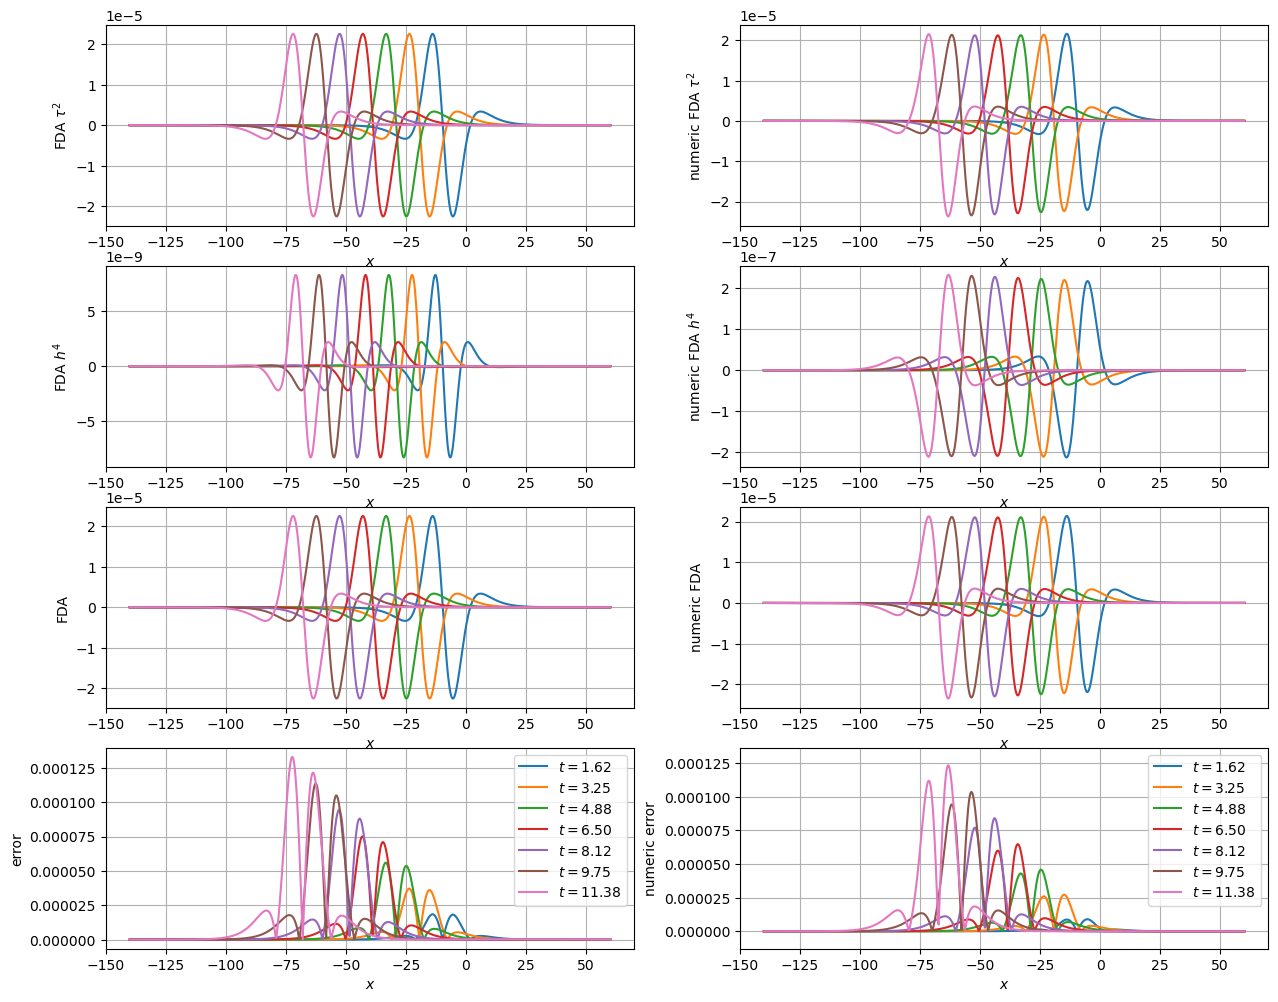

In [77]:
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve7-ex1.pdf")
draw1(sol, ex1, ex1FDAtau, ex1FDAh, 4, args, name="solve7-ex1.png")

In [78]:
def ex2FDAh(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return -32*k**9*(tanh(xi) - 1)*(tanh(xi) + 1)*(945*tanh(xi)**6\
        - 1800*tanh(xi)**4 + 1014*tanh(xi)**2 - 152)*tanh(xi)/15
    
def ex2FDAtau(t, x, args):
    k = args[0]
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3

In [79]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [80]:
%%time
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
dx = x[1] - x[0]
dt = 2.5*dx
sol = solve7(ex2(0., x, args), dt, dx, 600., 7)

dt=0.3125, t1=600.0, шагов=1920, вывод через 274 шагов
_ _ _ _ _ _ 
CPU times: user 12.2 s, sys: 28 ms, total: 12.2 s
Wall time: 12.4 s


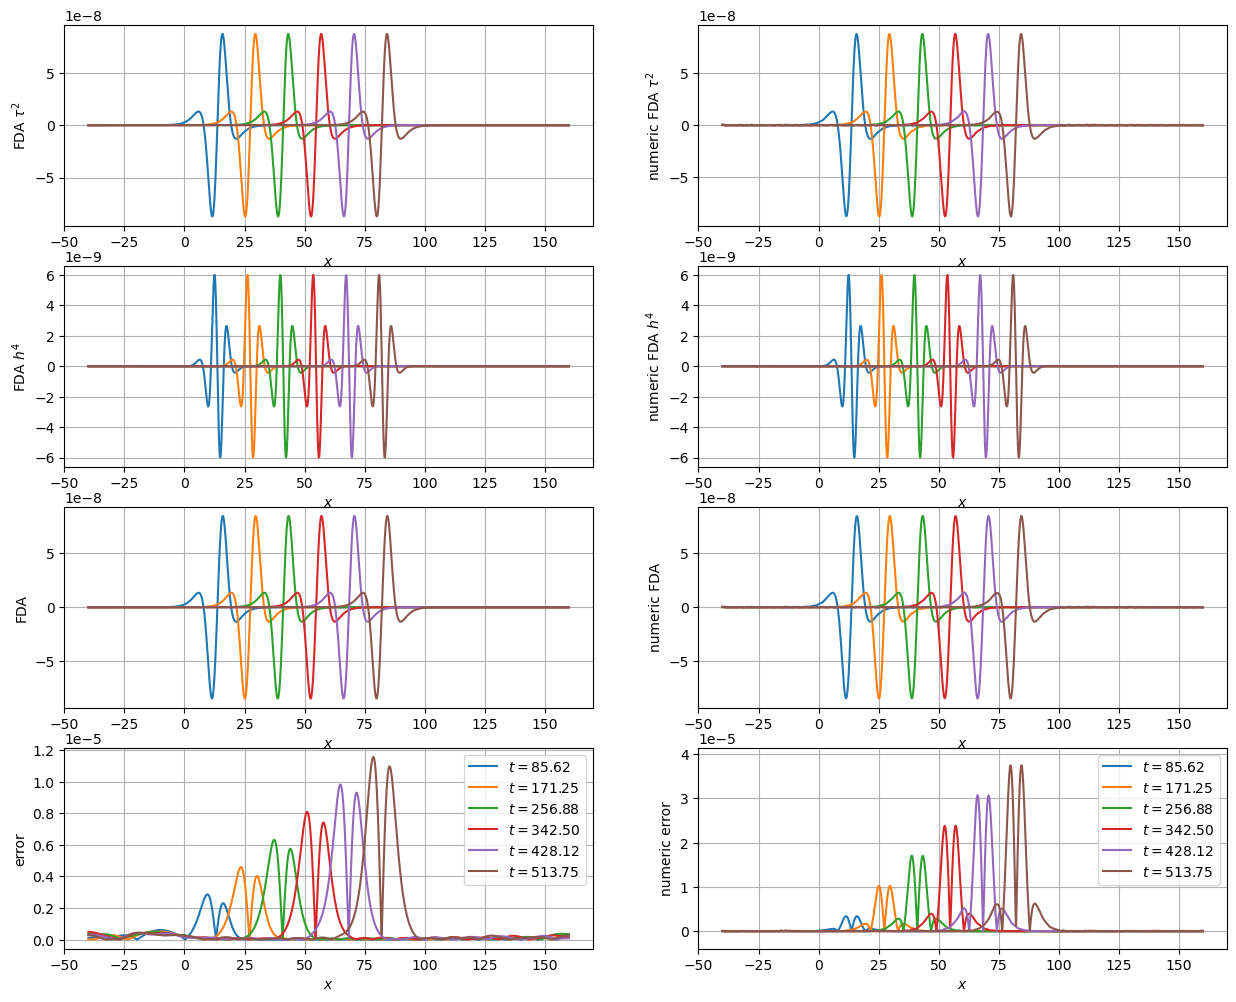

In [81]:
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve7-ex2.pdf")
draw1(sol, ex2, ex2FDAtau, ex2FDAh, 4, args, name="solve7-ex2.png")

In [82]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [83]:
%%time
x = array(linspace(-L*.2, L*.6, N), dtype=float64)
k1, k2, delta = 0.5, 0.2, 3.
args = [k1, k2, delta]
dx = x[1] - x[0]
dt = 2.5*dx
sol = solve7(ex3(0., x, args), dt, dx, 100., 7)

dt=0.25000000000000355, t1=100.0, шагов=399, вывод через 57 шагов
_ _ _ _ _ _ 
CPU times: user 3.01 s, sys: 15.9 ms, total: 3.03 s
Wall time: 3.04 s


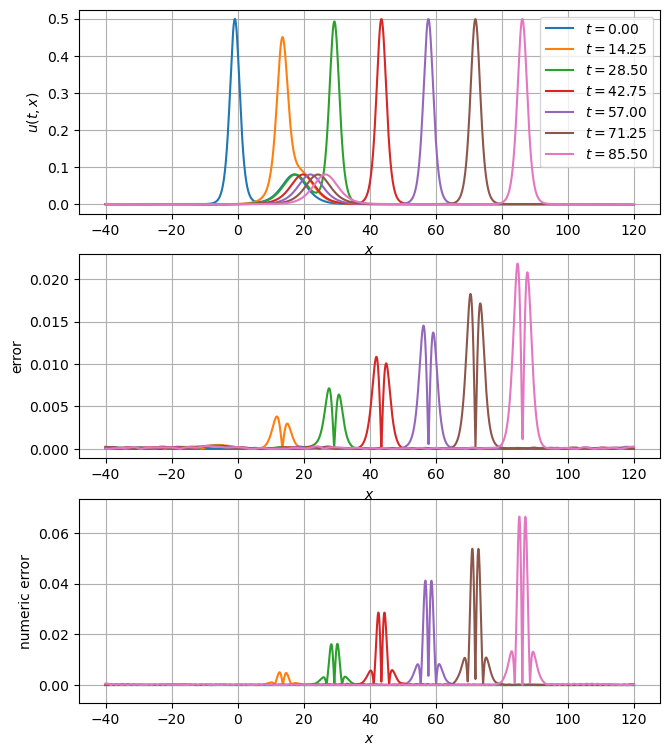

In [84]:
draw(sol, ex3, name="")
draw(sol, ex3, name="solve7-ex3.pdf")
draw(sol, ex3, name="solve7-ex3.png")